<a href="https://colab.research.google.com/github/gabriel-masson/Chika_2025.1/blob/main/PAHO_Guideline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


from sklearn.model_selection import cross_val_score, LeaveOneOut, KFold

from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

#-

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/_MESTRADO/REPLICK/Base de Dados/V2_BANCO_DOTLAB_347.xlsx')
df.head()

,PID,D0_Diagnóstico CHIKV,D0_Método diagnóstico,D0_Data de início dos sintomas,D0_Data de recrutamento,D0_Fase CHIKF (D0),D0_DPIS ambulat-D0,D0_Dias após inicio de sintomas (DPIS)- recrut,D0_Novo critério (0-3/4-10),D0_Critério anterior (0/1-10),...,D0_intensdor_dedomaod,D0_intensdor_quadrile,D0_intensdor_quadrild,D0_intensdor_joelhoe,D0_intensdor_joelhod,D0_intensdor_tornozeloe,D0_intensdor_tornozelod,D0_intensdor_dedopee,D0_intensdor_dedoped,D0_categoria_ativdoenca
0,REC001,Positivo,TR,2019-08-01,2019-09-09,Subagudo,28,39,1,1,...,4,1,1,3,3,4,4,3,2,3
1,REC002,Positivo,TR,2019-09-01,2019-09-16,Subagudo,10,15,1,1,...,4,4,4,4,4,4,4,1,1,2
2,REC004,Positivo,RT-qPCR (ZDC),2020-07-04,2020-07-08,Agudo,4,4,1,1,...,4,1,1,1,1,1,1,1,1,4
3,REC005,Positivo,TR,2020-05-26,2020-07-08,Subagudo,43,43,1,1,...,3,2,2,2,2,4,4,3,3,4
4,REC006,Positivo,TR,2020-06-19,2020-07-13,Subagudo,24,24,1,1,...,2,1,1,1,1,2,2,3,2,3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Columns: 252 entries, PID to D0_categoria_ativdoenca
dtypes: datetime64[ns](4), float64(12), int64(227), object(9)
memory usage: 683.3+ KB


In [ ]:
df['D0_disestesia_episodio1'].fillna(0,inplace=True) # Changed 'filla' to 'fillna'

<ipython-input-6-302483115fcd>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['D0_disestesia_episodio1'].fillna(0,inplace=True) # Changed 'filla' to 'fillna'


##Utils

In [ ]:
def avaliation_model(y_test,y_pred):
  metricas = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True, zero_division=1)).round(4).T.drop('support', axis=1)
  metricas.drop(['macro avg', 'weighted avg'], axis=0, inplace=True)
  auc = roc_auc_score(y_test, y_pred)

  accuracy= (metricas.loc["accuracy", "f1-score"]*100).round(6)
  recall= (metricas.loc["1", "recall"]*100).round(6)
  especificity= (metricas.loc["0", "recall"]*100).round(6)
  precision= (metricas.loc["1", "precision"]*100).round(6)
  f1_score= (metricas.loc["1", "f1-score"]*100).round(6)
  AUC= (auc*100).round(2)
  print(f'Accuracy: {accuracy}')
  print(f'Recall: {recall}')
  print(f'Rspecificity: {especificity}')
  print(f'Precision: {precision}')
  print(f'F1_score: {f1_score}')
  print(f'AUC: {AUC}')


In [ ]:
#average = (qte_class_positive + qte_class_negative)/2
average = 173
def train_avaliation_model(df_train, model, scenery = " "):
  print("=*="*4)
  print(scenery)

  X = df_train.drop('D0_Novo critério (0-3/4-10)', axis=1)
  y = df_train['D0_Novo critério (0-3/4-10)']

  X = df_train.drop('D0_Novo critério (0-3/4-10)', axis=1)

  y = df_train['D0_Novo critério (0-3/4-10)'].astype(int)

  under_sampler = RandomUnderSampler(sampling_strategy={1: average}, random_state=42)
  over_sampler = RandomOverSampler(sampling_strategy={0: average}, random_state=42)

  X_resampled, y_resampled = under_sampler.fit_resample(X, y)
  X_resampled, y_resampled = over_sampler.fit_resample(X_resampled, y_resampled)

  X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  avaliation_model(y_test,y_pred)


In [ ]:
def cross_val_models_f1(df_train, model):
    X = df_train.drop('D0_Novo critério (0-3/4-10)', axis=1)
    y = df_train['D0_Novo critério (0-3/4-10)'].astype(int)

    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    f1_scorer = make_scorer(f1_score, average='weighted')

    cross_model = cross_validate(model, X, y, cv=kf, scoring=f1_scorer)
    return cross_model['test_score']

In [ ]:
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth= 79, max_features='log2', min_samples_leaf= 9, min_samples_split= 7, random_state=42)
rf_model = RandomForestClassifier(criterion= 'gini', n_estimators= 974, max_depth= 1000, min_samples_split= 0.01, min_samples_leaf= 0.01, random_state=42)
svm_model = SVC(kernel= 'linear', degree= 2, gamma= 4.2594025, C= 0.010007202, random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42, colsample_bytree= 0.239900212, learning_rate= 0.068163796, max_depth= 780, n_estimators= 699, subsample= 0.067780561)
ada_model = AdaBoostClassifier(n_estimators= 502, learning_rate= 0.2607703, algorithm= "SAMME", random_state=42)
gb_model = GradientBoostingClassifier(n_estimators= 288, learning_rate= 0.0182112977748381, max_depth= 999,min_samples_split= 0.01, min_samples_leaf= 0.403862979577575,)
models = [dt_model, rf_model, svm_model, xgb_model, ada_model, gb_model]

##Test without PAHO

In [ ]:
df.columns

Index(['PID', 'D0_Diagnóstico CHIKV', 'D0_Método diagnóstico',
       'D0_Data de início dos sintomas', 'D0_Data de recrutamento',
       'D0_Fase CHIKF (D0)', 'D0_DPIS ambulat-D0',
       'D0_Dias após inicio de sintomas (DPIS)- recrut',
       'D0_Novo critério (0-3/4-10)', 'D0_Critério anterior (0/1-10)',
       ...
       'D0_intensdor_dedomaod', 'D0_intensdor_quadrile',
       'D0_intensdor_quadrild', 'D0_intensdor_joelhoe', 'D0_intensdor_joelhod',
       'D0_intensdor_tornozeloe', 'D0_intensdor_tornozelod',
       'D0_intensdor_dedopee', 'D0_intensdor_dedoped',
       'D0_categoria_ativdoenca'],
      dtype='object', length=252)

In [ ]:
#Features segundo GUIDELINES FOR THE CLINICAL DIAGNOSIS AND TREATMENT OF DENGUE, CHIKUNGUNYA, AND ZIKA By PAHO

features = [ 'D0_idade', 'D0_genero', 'D0_cor',

            'D0_febre_episodio1',         'D0_cefaleia_episodio1',          'D0_fadiga_episodio1',
             'D0_palidez_episodio1',     'D0_hiperemia_episodio1',          'D0_turvacao_episodio1',
             'D0_nausea_episodio1',      'D0_vomito_episodio1',             'D0_diarreia_episodio1',
             'D0_parestesia_episodio1',  'D0_disestesia_episodio1',         'D0_artralgia_episodio1',
             'D0_edema_episodio1',       'D0_mialgia_episodio1',            'D0_lombalgia_episodio1',
             'D0_prurido_episodio1',     'D0_rash_episodio1',               'D0_lesoes_episodio1',
             'D0_alopecia_episodio1',    'D0_alteracaomemoria_episodio1',   'D0_alteracaolibido_episodio1',
             'D0_enpp_fadiga',

            #  'D0_intensdor_ombroe',
            #  'D0_intensdor_ombrod',
            #  'D0_intensdor_punhoe',
            #  'D0_intensdor_punhod',
            #  'D0_intensdor_dedomaoe',
            #  'D0_intensdor_dedomaod',
            #  'D0_intensdor_joelhoe',
            #  'D0_intensdor_joelhod',
            #  'D0_intensdor_tornozeloe',
            #  'D0_intensdor_tornozelod',
            #  'D0_intensdor_dedopee',
            #  'D0_intensdor_dedoped',
             'D0_Novo critério (0-3/4-10)',

            'D0_Dias após inicio de sintomas (DPIS)- recrut', 'D0_DPIS ambulat-D0',
]

df = df[features]

'D0_Dias após inicio de sintomas (DPIS)- recrut' == 'D0_Data de início dos sintomas' - 'D0_Data de recrutamento'

In [ ]:
df.head()

,D0_idade,D0_genero,D0_cor,D0_febre_episodio1,D0_cefaleia_episodio1,D0_fadiga_episodio1,D0_palidez_episodio1,D0_hiperemia_episodio1,D0_turvacao_episodio1,D0_nausea_episodio1,...,D0_prurido_episodio1,D0_rash_episodio1,D0_lesoes_episodio1,D0_alopecia_episodio1,D0_alteracaomemoria_episodio1,D0_alteracaolibido_episodio1,D0_enpp_fadiga,D0_Novo critério (0-3/4-10),D0_Dias após inicio de sintomas (DPIS)- recrut,D0_DPIS ambulat-D0
0,34,2,3,1,0,1,0,0,0,0,...,0,1,0,0,0,0,7,1,39,28
1,67,2,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,5,1,15,10
2,48,2,1,1,0,1,0,1,0,0,...,1,1,1,0,0,0,0,1,4,4
3,47,2,1,1,1,1,0,0,0,0,...,0,1,0,1,0,1,5,1,43,43
4,23,2,3,1,0,1,0,0,0,0,...,1,1,0,0,0,0,3,1,24,24


In [ ]:
fs_high = ['D0_artralgia_episodio1']
fs_mid = ['D0_mialgia_episodio1','D0_lesoes_episodio1']
fs_low = ['D0_febre_episodio1',       'D0_cefaleia_episodio1',   'D0_fadiga_episodio1',
     'D0_palidez_episodio1',     'D0_hiperemia_episodio1',  'D0_turvacao_episodio1',
     'D0_nausea_episodio1',      'D0_vomito_episodio1',     'D0_diarreia_episodio1',
     'D0_parestesia_episodio1',  'D0_disestesia_episodio1', 'D0_edema_episodio1',
     'D0_lombalgia_episodio1',   'D0_prurido_episodio1',    'D0_rash_episodio1',
     'D0_alopecia_episodio1',    'D0_alteracaomemoria_episodio1',   'D0_alteracaolibido_episodio1',
     'D0_enpp_fadiga', ]

fs_dores = [           'D0_intensdor_ombroe',
             'D0_intensdor_ombrod',
             'D0_intensdor_punhoe',
             'D0_intensdor_punhod',
             'D0_intensdor_dedomaoe',
             'D0_intensdor_dedomaod',
             'D0_intensdor_joelhoe',
             'D0_intensdor_joelhod',
             'D0_intensdor_tornozeloe',
             'D0_intensdor_tornozelod',
             'D0_intensdor_dedopee',
             'D0_intensdor_dedoped',]

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

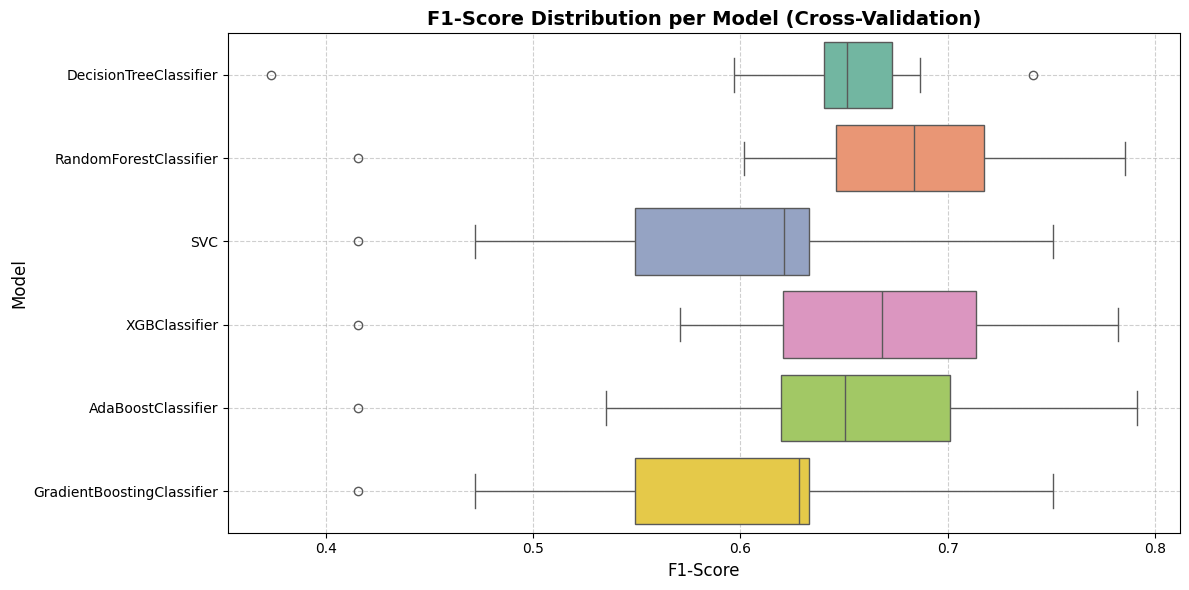

In [ ]:
models = {
    "DecisionTreeClassifier":  DecisionTreeClassifier(criterion='entropy', max_depth= 79, max_features='log2', min_samples_leaf= 9, min_samples_split= 7, random_state=42),
    "RandomForestClassifier": RandomForestClassifier(criterion= 'gini', n_estimators= 974, max_depth= 1000, min_samples_split= 0.01, min_samples_leaf= 0.01, random_state=42),
    "SVC": SVC(kernel= 'linear', degree= 2, gamma= 4.2594025, C= 0.010007202, random_state=42),
    "XGBClassifier": xgb.XGBClassifier(random_state=42, colsample_bytree= 0.239900212, learning_rate= 0.068163796, max_depth= 780, n_estimators= 699, subsample= 0.067780561),
    "AdaBoostClassifier": AdaBoostClassifier(n_estimators= 502, learning_rate= 0.2607703, algorithm= "SAMME", random_state=42),
    "GradientBoostingClassifier": GradientBoostingClassifier(n_estimators= 288, learning_rate= 0.0182112977748381, max_depth= 999,min_samples_split= 0.01, min_samples_leaf= 0.403862979577575,)
}


f1_scores = {}
for model_name, model in models.items():
    f1_scores[model_name] = cross_val_models_f1(df, model)

# Convert to DataFrame for ease of use with seaborn
f1_df = pd.DataFrame([
    {'Model': model_name, 'F1 Score': score}
    for model_name, scores in f1_scores.items()
    for score in scores
])

# Plot com seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(data=f1_df, y='Model', x='F1 Score', palette='Set2')
plt.title('F1-Score Distribution per Model (Cross-Validation)', fontsize=14, fontweight='bold')
plt.xlabel('F1-Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
for model_name, model in models.items(): # Iterate through key-value pairs
  train_avaliation_model(df, model, model_name) # Use model_name instead of model.__class__.__name__

=*==*==*==*=
DecisionTreeClassifier
Accuracy: 66.35
Recall: 86.79
Rspecificity: 45.1
Precision: 62.16
F1_score: 72.44
AUC: 65.95
=*==*==*==*=
RandomForestClassifier
Accuracy: 66.35
Recall: 67.92
Rspecificity: 64.71
Precision: 66.67
F1_score: 67.29
AUC: 66.32
=*==*==*==*=
SVC
Accuracy: 56.73
Recall: 56.6
Rspecificity: 56.86
Precision: 57.69
F1_score: 57.14
AUC: 56.73
=*==*==*==*=
XGBClassifier
Accuracy: 53.85
Recall: 58.49
Rspecificity: 49.02
Precision: 54.39
F1_score: 56.36
AUC: 53.76
=*==*==*==*=
AdaBoostClassifier


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Accuracy: 52.88
Recall: 49.06
Rspecificity: 56.86
Precision: 54.17
F1_score: 51.49
AUC: 52.96
=*==*==*==*=
GradientBoostingClassifier
Accuracy: 58.65
Recall: 54.72
Rspecificity: 62.75
Precision: 60.42
F1_score: 57.43
AUC: 58.73


#calc weight

In [ ]:
df.columns

Index(['PID', 'D0_Diagnóstico CHIKV', 'D0_Método diagnóstico',
       'D0_Data de início dos sintomas', 'D0_Data de recrutamento',
       'D0_Fase CHIKF (D0)', 'D0_DPIS ambulat-D0',
       'D0_Dias após inicio de sintomas (DPIS)- recrut',
       'D0_Novo critério (0-3/4-10)', 'D0_Critério anterior (0/1-10)',
       ...
       'D0_intensdor_dedomaod', 'D0_intensdor_quadrile',
       'D0_intensdor_quadrild', 'D0_intensdor_joelhoe', 'D0_intensdor_joelhod',
       'D0_intensdor_tornozeloe', 'D0_intensdor_tornozelod',
       'D0_intensdor_dedopee', 'D0_intensdor_dedoped',
       'D0_categoria_ativdoenca'],
      dtype='object', length=252)

####Calculando os pesos

In [ ]:
def calc_weight(x0, x1, x, y0, y1):

  intervalo = x1 - x0
  w = (y1-y0)
  intervalo = intervalo * w
  tempo_total = x - x0
  y = y0 + (intervalo/tempo_total)
  return y




In [ ]:
x1 = df['D0_DPIS ambulat-D0'] #Days after onset of symptoms in which the individual made an outpatient appointment
x0 = df['D0_Dias após inicio de sintomas (DPIS)- recrut'] #Days after onset of symptoms that the individual was recruited and the sample collected

In [ ]:
for col in fs_high:
  df[col] = calc_weight(x0 =x0, x1 = x1, x = 90, y0 = 0.76, y1= 1)
for col in fs_mid:
  df[col] = calc_weight(x0 =x0, x1 = x1, x = 90, y0 = 0.51, y1= 0.75)

for col in fs_low:
  df[col] = calc_weight(x0 =x0, x1 = x1, x = 90, y0 = 0.25, y1= 0.5)

In [ ]:
df.columns

Index(['D0_idade', 'D0_genero', 'D0_cor', 'D0_febre_episodio1',
       'D0_cefaleia_episodio1', 'D0_fadiga_episodio1', 'D0_palidez_episodio1',
       'D0_hiperemia_episodio1', 'D0_turvacao_episodio1',
       'D0_nausea_episodio1', 'D0_vomito_episodio1', 'D0_diarreia_episodio1',
       'D0_parestesia_episodio1', 'D0_disestesia_episodio1',
       'D0_artralgia_episodio1', 'D0_edema_episodio1', 'D0_mialgia_episodio1',
       'D0_lombalgia_episodio1', 'D0_prurido_episodio1', 'D0_rash_episodio1',
       'D0_lesoes_episodio1', 'D0_alopecia_episodio1',
       'D0_alteracaomemoria_episodio1', 'D0_alteracaolibido_episodio1',
       'D0_enpp_fadiga', 'D0_Novo critério (0-3/4-10)',
       'D0_Dias após inicio de sintomas (DPIS)- recrut', 'D0_DPIS ambulat-D0'],
      dtype='object')

In [ ]:
df = df.drop(['D0_Dias após inicio de sintomas (DPIS)- recrut', 'D0_DPIS ambulat-D0'], axis=1)

#Testing models

##Visualization

In [ ]:
models = {
    "DecisionTreeClassifier":  DecisionTreeClassifier(criterion='entropy', max_depth= 79, max_features='log2', min_samples_leaf= 9, min_samples_split= 7, random_state=42),
    "RandomForestClassifier": RandomForestClassifier(criterion= 'gini', n_estimators= 974, max_depth= 1000, min_samples_split= 0.01, min_samples_leaf= 0.01, random_state=42),
    "SVC": SVC(kernel= 'linear', degree= 2, gamma= 4.2594025, C= 0.010007202, random_state=42),
    "XGBClassifier": xgb.XGBClassifier(random_state=42, colsample_bytree= 0.239900212, learning_rate= 0.068163796, max_depth= 780, n_estimators= 699, subsample= 0.067780561),
    "AdaBoostClassifier": AdaBoostClassifier(n_estimators= 502, learning_rate= 0.2607703, algorithm= "SAMME", random_state=42),
    "GradientBoostingClassifier": GradientBoostingClassifier(n_estimators= 288, learning_rate= 0.0182112977748381, max_depth= 999,min_samples_split= 0.01, min_samples_leaf= 0.403862979577575,)
}

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

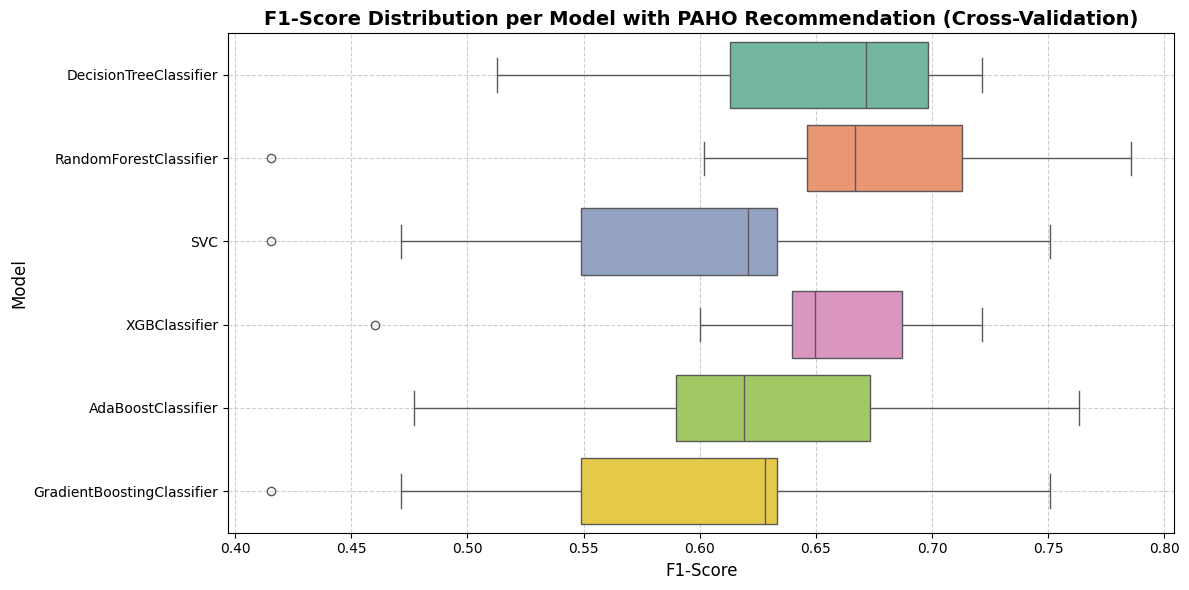

In [ ]:
# Carregar e preparar o DataFrame df_train aqui...

# Armazenar resultados de F1-score para cada modelo
f1_scores = {}
for model_name, model in models.items():
    f1_scores[model_name] = cross_val_models_f1(df, model)

# Converter para DataFrame para facilitar o uso com seaborn
f1_df = pd.DataFrame([
    {'Model': model_name, 'F1 Score': score}
    for model_name, scores in f1_scores.items()
    for score in scores
])

# Plot com seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(data=f1_df, y='Model', x='F1 Score', palette='Set2')
plt.title('F1-Score Distribution per Model with PAHO Recommendation (Cross-Validation)', fontsize=14, fontweight='bold')
plt.xlabel('F1-Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
for model_name, model in models.items(): # Iterate through key-value pairs
  train_avaliation_model(df, model, model_name) # Use model_name instead of model.__class__.__name__

=*==*==*==*=
DecisionTreeClassifier
Accuracy: 59.62
Recall: 47.17
Rspecificity: 72.55
Precision: 64.1
F1_score: 54.35
AUC: 59.86
=*==*==*==*=
RandomForestClassifier
Accuracy: 65.38
Recall: 67.92
Rspecificity: 62.75
Precision: 65.45
F1_score: 66.67
AUC: 65.33
=*==*==*==*=
SVC
Accuracy: 53.85
Recall: 50.94
Rspecificity: 56.86
Precision: 55.1
F1_score: 52.94
AUC: 53.9
=*==*==*==*=
XGBClassifier
Accuracy: 59.62
Recall: 56.6
Rspecificity: 62.75
Precision: 61.22
F1_score: 58.82
AUC: 59.67
=*==*==*==*=
AdaBoostClassifier


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Accuracy: 55.77
Recall: 52.83
Rspecificity: 58.82
Precision: 57.14
F1_score: 54.9
AUC: 55.83
=*==*==*==*=
GradientBoostingClassifier
Accuracy: 53.85
Recall: 54.72
Rspecificity: 52.94
Precision: 54.72
F1_score: 54.72
AUC: 53.83


In [ ]:
for col in fs_high:
  df[col] = calc_weight(x0 =x0, x1 = x1, x = 90, y0 = 0.66, y1= 1)
for col in fs_mid:
  df[col] = calc_weight(x0 =x0, x1 = x1, x = 90, y0 = 0.34, y1= 0.65)

for col in fs_low:
  df[col] = calc_weight(x0 =x0, x1 = x1, x = 90, y0 = 0.0, y1= 0.33)

=*==*==*==*=
DecisionTreeClassifier
Accuracy: 56.73
Recall: 52.83
Rspecificity: 60.78
Precision: 58.33
F1_score: 55.45
AUC: 56.81
=*==*==*==*=
RandomForestClassifier
Accuracy: 61.54
Recall: 60.38
Rspecificity: 62.75
Precision: 62.75
F1_score: 61.54
AUC: 61.56
=*==*==*==*=
SVC
Accuracy: 52.88
Recall: 64.15
Rspecificity: 41.18
Precision: 53.12
F1_score: 58.12
AUC: 52.66
=*==*==*==*=
XGBClassifier
Accuracy: 59.62
Recall: 66.04
Rspecificity: 52.94
Precision: 59.32
F1_score: 62.5
AUC: 59.49
=*==*==*==*=
AdaBoostClassifier


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Accuracy: 57.69
Recall: 67.92
Rspecificity: 47.06
Precision: 57.14
F1_score: 62.07
AUC: 57.49
=*==*==*==*=
GradientBoostingClassifier
Accuracy: 54.81
Recall: 67.92
Rspecificity: 41.18
Precision: 54.55
F1_score: 60.5
AUC: 54.55


In [ ]:
for model_name, model in models.items(): # Iterate through key-value pairs
  train_avaliation_model(df, model, model_name) # Use model_name instead of model.__class__.__name__

=*==*==*==*=
DecisionTreeClassifier
Accuracy: 56.73
Recall: 52.83
Rspecificity: 60.78
Precision: 58.33
F1_score: 55.45
AUC: 56.81
=*==*==*==*=
RandomForestClassifier
Accuracy: 61.54
Recall: 60.38
Rspecificity: 62.75
Precision: 62.75
F1_score: 61.54
AUC: 61.56
=*==*==*==*=
SVC
Accuracy: 52.88
Recall: 64.15
Rspecificity: 41.18
Precision: 53.12
F1_score: 58.12
AUC: 52.66
=*==*==*==*=
XGBClassifier
Accuracy: 59.62
Recall: 66.04
Rspecificity: 52.94
Precision: 59.32
F1_score: 62.5
AUC: 59.49
=*==*==*==*=
AdaBoostClassifier


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Accuracy: 57.69
Recall: 67.92
Rspecificity: 47.06
Precision: 57.14
F1_score: 62.07
AUC: 57.49
=*==*==*==*=
GradientBoostingClassifier
Accuracy: 54.81
Recall: 67.92
Rspecificity: 41.18
Precision: 54.55
F1_score: 60.5
AUC: 54.55


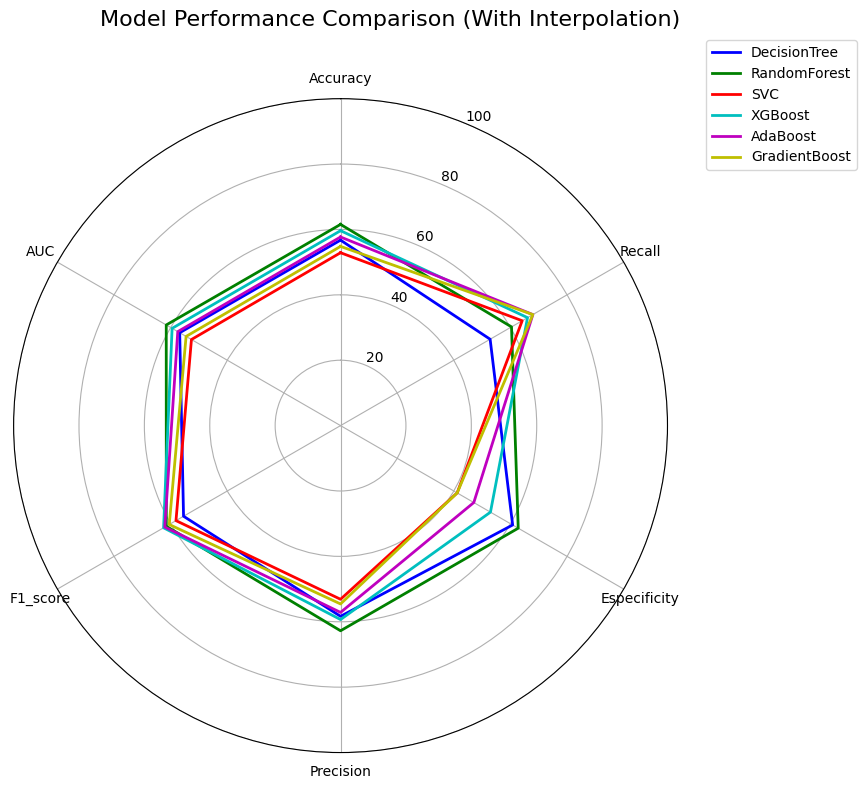

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


data = {
    "Metric": ["Accuracy", "Recall", "Especificity", "Precision", "F1_score", "AUC"],
    "DecisionTree": [56.73, 52.83, 60.78, 58.33, 55.45, 56.81],
    "RandomForest": [61.54, 60.38, 62.75, 62.75, 61.54, 61.56],
    "SVC": [52.88, 64.15, 41.18, 53.12, 58.12, 52.66],
    "XGBoost": [59.62, 66.04, 52.94, 59.32, 62.5, 59.49],
    "AdaBoost": [57.69, 67.92, 47.06, 57.14, 62.07, 57.49],
    "GradientBoost": [54.81, 67.92, 41.18, 54.55, 60.5, 54.55]
}


df = pd.DataFrame(data)


labels = df["Metric"].values
num_vars = len(labels)

# Angles for the radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]


fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# Colors for each model
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Add each model to the graph
for i, (model, color) in enumerate(zip(df.columns[1:], colors)):
    values = df[model].values.tolist()
    values += values[:1]
    ax.plot(angles, values, label=model, color=color, linewidth=2)
    #fill the inside figure
    # ax.fill(angles, values, color=color, alpha=0.1)



fig.suptitle("Model Performance Comparison (With Interpolation)", fontsize=16)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0, 100)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()

# Mostrar gráfico
plt.show()


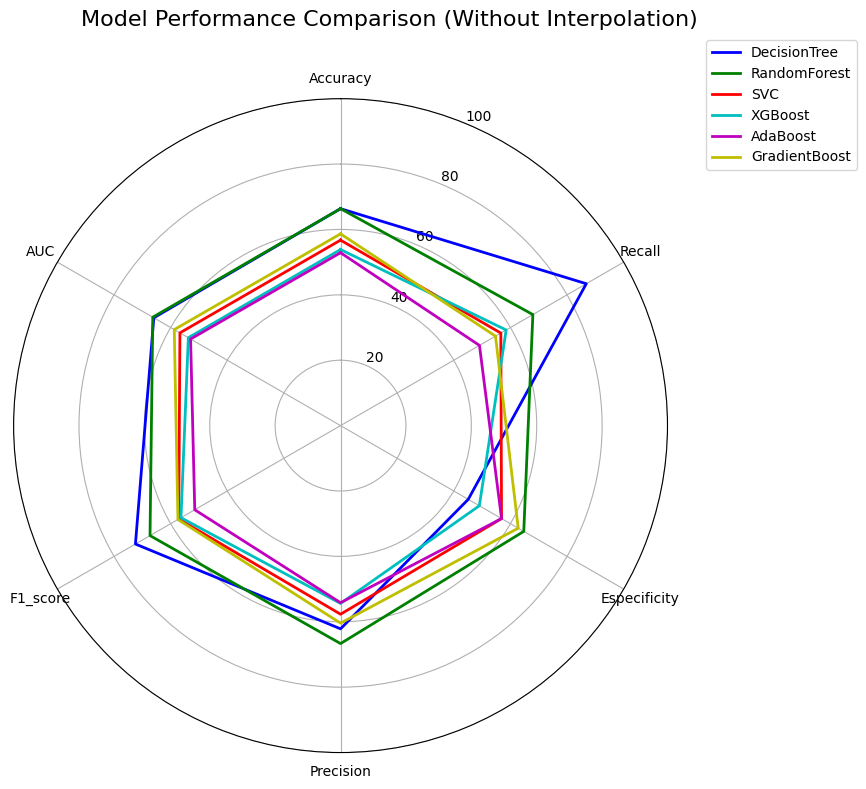

In [ ]:
# New data for the "Without PAHO recommendation" chart
data_without_paho = {
    "Metric": ["Accuracy", "Recall", "Especificity", "Precision", "F1_score", "AUC"],
    "DecisionTree": [66.35, 86.79, 45.1, 62.16, 72.44, 65.95],
    "RandomForest": [66.35, 67.92, 64.71, 66.67, 67.29, 66.32],
    "SVC": [56.73, 56.6, 56.86, 57.69, 57.14, 56.73],
    "XGBoost": [53.85, 58.49, 49.02, 54.39, 56.36, 53.76],
    "AdaBoost": [52.88, 49.06, 56.86, 54.17, 51.49, 52.96],
    "GradientBoost": [58.65, 54.72, 62.75, 60.42, 57.43, 58.73]
}


df2 = pd.DataFrame(data_without_paho)

angles2 = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles2 += angles2[:1]


fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# Add each model to the graph
for i, (model, color) in enumerate(zip(df2.columns[1:], colors)):
    values = df2[model].values.tolist()
    values += values[:1]
    ax.plot(angles2, values, label=model, color=color, linewidth=2)
    # ax.fill(angles2, values, color=color, alpha=0.1)

fig.suptitle("Model Performance Comparison (Without Interpolation)", fontsize=16)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles2[:-1]), labels)
ax.set_ylim(0, 100)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()


plt.show()
